In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style="whitegrid")


In [23]:
def load_data(path):
    df = pd.read_csv(path)
    
    # ensure boolean is correct
    if df["greedy_better"].dtype != bool:
        df["greedy_better"] = df["greedy_better"].astype(bool)
    
    return df

def aggregate_results(df):
    summary = df.groupby(
        ["n", "density", "weight_min", "weight_max"]
    ).agg({
        "cycle_val": "mean",
        "greedy_val": "mean",
        "UB_val": "mean",
        "cycle_time": "mean",
        "greedy_time": "mean",
        "greedy_better": "mean"
    }).reset_index()
    
    # add differences
    summary["time_diff"] = summary["greedy_time"] - summary["cycle_time"]
    summary["val_diff"] = summary["greedy_val"] - summary["cycle_val"]
    
    return summary



In [6]:
def plot_runtime_vs_n(summary, density, weight_min, weight_max):
    subset = summary[
        (summary["density"] == density) &
        (summary["weight_min"] == weight_min) &
        (summary["weight_max"] == weight_max)
    ].sort_values("n")
    
    plt.figure()
    plt.plot(subset["n"], subset["cycle_time"], label="Cycle relaxation")
    plt.plot(subset["n"], subset["greedy_time"], label="Greedy packing")
    
    plt.xlabel("n")
    plt.ylabel("Average runtime (seconds)")
    plt.title(f"Runtime scaling (density={density}, weights={weight_min}-{weight_max})")
    plt.legend()
    plt.show()


In [ ]:
def plot_lower_bounds_vs_n(summary, density, weight_min, weight_max):
    subset = summary[
        (summary["density"] == density) &
        (summary["weight_min"] == weight_min) &
        (summary["weight_max"] == weight_max)
    ].sort_values("n")
    
    plt.figure()
    plt.plot(subset["n"], subset["cycle_val"], label="Cycle LB")
    plt.plot(subset["n"], subset["greedy_val"], label="Greedy LB")
    plt.plot(subset["n"], subset["UB_val"], label="Upper bound", linestyle="dashed")
    
    plt.xlabel("n")
    plt.ylabel("Average lower bound value")
    plt.title(f"Lower bounds comparison (density={density}, weights={weight_min}-{weight_max})")
    plt.legend()
    plt.show()


In [8]:
def plot_runtime_heatmap(summary, weight_min, weight_max):
    subset = summary[
        (summary["weight_min"] == weight_min) &
        (summary["weight_max"] == weight_max)
    ]
    
    pivot = subset.pivot(index="n", columns="density", values="time_diff")
    
    plt.figure()
    sns.heatmap(pivot, annot=False, cmap="coolwarm", center=0)
    plt.title(f"Runtime difference (Greedy - Cycle)\nweights={weight_min}-{weight_max}")
    plt.xlabel("Density")
    plt.ylabel("n")
    plt.show()


In [9]:
def plot_greedy_dominance(summary, weight_min, weight_max):
    subset = summary[
        (summary["weight_min"] == weight_min) &
        (summary["weight_max"] == weight_max)
    ]
    
    pivot = subset.pivot(index="n", columns="density", values="greedy_better")
    
    plt.figure()
    sns.heatmap(pivot, annot=False, cmap="viridis")
    plt.title(f"Proportion Greedy Better\nweights={weight_min}-{weight_max}")
    plt.xlabel("Density")
    plt.ylabel("n")
    plt.show()


In [10]:
def plot_log_scaling(summary, density, weight_min, weight_max):
    subset = summary[
        (summary["density"] == density) &
        (summary["weight_min"] == weight_min) &
        (summary["weight_max"] == weight_max)
    ].sort_values("n")
    
    plt.figure()
    plt.loglog(subset["n"], subset["cycle_time"], marker='o', label="Cycle")
    plt.loglog(subset["n"], subset["greedy_time"], marker='o', label="Greedy")
    
    plt.xlabel("n (log)")
    plt.ylabel("Runtime (log)")
    plt.title("Log-log runtime scaling")
    plt.legend()
    plt.show()


In [27]:
def prepare_data(csv_path):
    df = pd.read_csv(csv_path)

    if df["greedy_better"].dtype != bool:
        df["greedy_better"] = df["greedy_better"].astype(bool)

    summary = df.groupby(
        ["n", "density", "weight_min", "weight_max"]
    ).agg({
        "cycle_val": "mean",
        "greedy_val": "mean",
        "UB_val": "mean",
        "cycle_time": "mean",
        "greedy_time": "mean",
        "greedy_better": "mean"
    }).reset_index()

    summary["time_diff"] = summary["greedy_time"] - summary["cycle_time"]
    summary["val_diff"] = summary["greedy_val"] - summary["cycle_val"]

    return summary


In [28]:
def plot_all_experiments(csv_path, save=False, show=True):
    
    summary = prepare_data(csv_path)

    os.makedirs("figures", exist_ok=True)

    weight_regimes = summary[["weight_min", "weight_max"]].drop_duplicates().values
    densities = sorted(summary["density"].unique())

    for wmin, wmax in weight_regimes:

        subset_w = summary[
            (summary["weight_min"] == wmin) &
            (summary["weight_max"] == wmax)
        ]

        # =====================================================
        # 1️⃣ Runtime vs n (for each density)
        # =====================================================
        for density in densities:
            subset = subset_w[subset_w["density"] == density].sort_values("n")
            if subset.empty:
                continue

            plt.figure()
            plt.plot(subset["n"], subset["cycle_time"], marker='o', label="Cycle")
            plt.plot(subset["n"], subset["greedy_time"], marker='o', label="Greedy")

            plt.xlabel("n")
            plt.ylabel("Average runtime (seconds)")
            plt.title(f"Runtime vs n | density={density} | weights={wmin}-{wmax}")
            plt.legend()

            if save:
                plt.savefig(f"figures/runtime_n_d{density}_w{wmin}-{wmax}.png")

            if show:
                plt.show()
            else:
                plt.close()

        # =====================================================
        # 2️⃣ Lower Bounds vs n (for each density)
        # =====================================================
        for density in densities:
            subset = subset_w[subset_w["density"] == density].sort_values("n")
            if subset.empty:
                continue

            plt.figure(figsize=(7,5))

            plt.plot(subset["n"], subset["cycle_val"],
                    marker='o', linewidth=2,
                    label="Cycle relaxation (LB)")

            plt.plot(subset["n"], subset["greedy_val"],
                    marker='s', linewidth=2,
                    label="Greedy packing (LB)")

            plt.plot(subset["n"], subset["UB_val"],
                    marker='^', linestyle="--",
                    linewidth=2.5,
                    label="Upper bound")

            plt.xlabel("n")
            plt.ylabel("Objective value")
            plt.title(f"Bounds vs n | density={density} | weights={wmin}-{wmax}")
            plt.grid(True, linestyle="--", alpha=0.4)
            plt.legend()

            if save:
                plt.savefig(f"figures/lb_n_d{density}_w{wmin}-{wmax}.png",
                            bbox_inches="tight", dpi=300)

            if show:
                plt.show()
            else:
                plt.close()

        # =====================================================
        # 3️⃣ Runtime Heatmap (n vs density)
        # =====================================================
        pivot_time = subset_w.pivot(index="n", columns="density", values="time_diff")

        if not pivot_time.empty:
            plt.figure(figsize=(8,6))
            sns.heatmap(pivot_time, cmap="coolwarm", center=0)
            plt.title(f"Runtime Difference (Greedy - Cycle)\nweights={wmin}-{wmax}")
            plt.xlabel("Density")
            plt.ylabel("n")

            if save:
                plt.savefig(f"figures/runtime_heatmap_w{wmin}-{wmax}.png")

            if show:
                plt.show()
            else:
                plt.close()

        # =====================================================
        # 4️⃣ Greedy Dominance Heatmap
        # =====================================================
        pivot_dom = subset_w.pivot(index="n", columns="density", values="greedy_better")

        if not pivot_dom.empty:
            plt.figure(figsize=(8,6))
            sns.heatmap(pivot_dom, cmap="viridis", vmin=0, vmax=1)
            plt.title(f"Proportion Greedy Better\nweights={wmin}-{wmax}")
            plt.xlabel("Density")
            plt.ylabel("n")

            if save:
                plt.savefig(f"figures/greedy_dominance_w{wmin}-{wmax}.png")

            if show:
                plt.show()
            else:
                plt.close()

        # =====================================================
        # 5️⃣ Log-Log Scaling (largest density only)
        # =====================================================
        max_density = max(densities)
        subset = subset_w[subset_w["density"] == max_density].sort_values("n")

        if not subset.empty:
            plt.figure()
            plt.loglog(subset["n"], subset["cycle_time"], marker='o', label="Cycle")
            plt.loglog(subset["n"], subset["greedy_time"], marker='o', label="Greedy")

            plt.xlabel("n (log)")
            plt.ylabel("Runtime (log)")
            plt.title(f"Log-Log Scaling | density={max_density} | weights={wmin}-{wmax}")
            plt.legend()

            if save:
                plt.savefig(f"figures/loglog_w{wmin}-{wmax}.png")

            if show:
                plt.show()
            else:
                plt.close()

    print("All plots generated.")


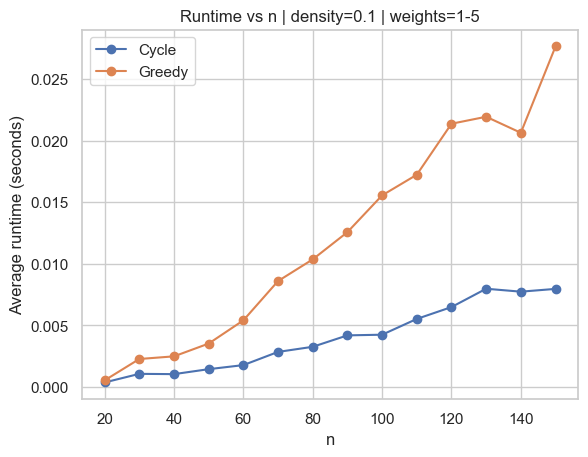

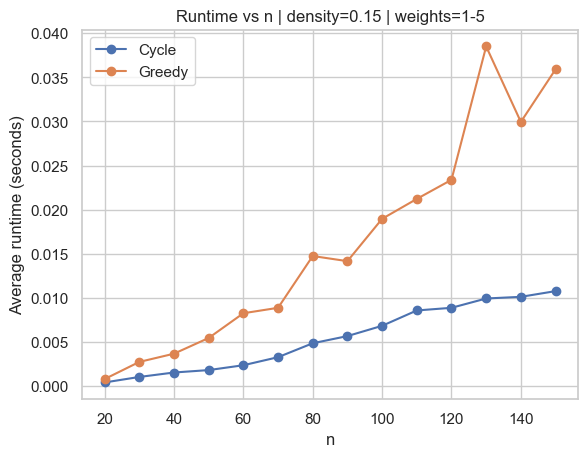

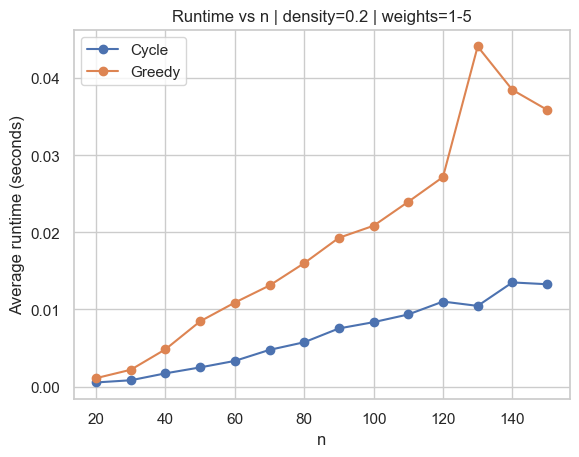

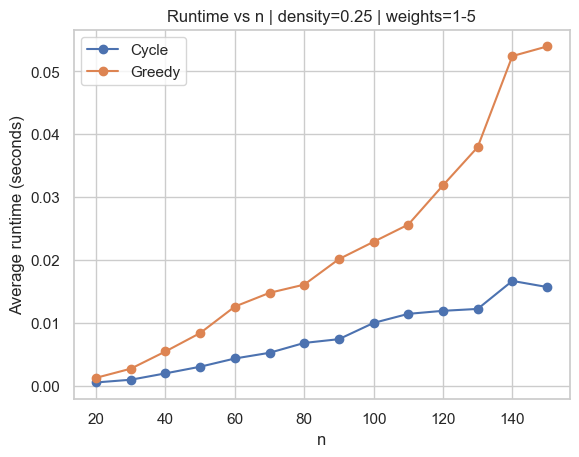

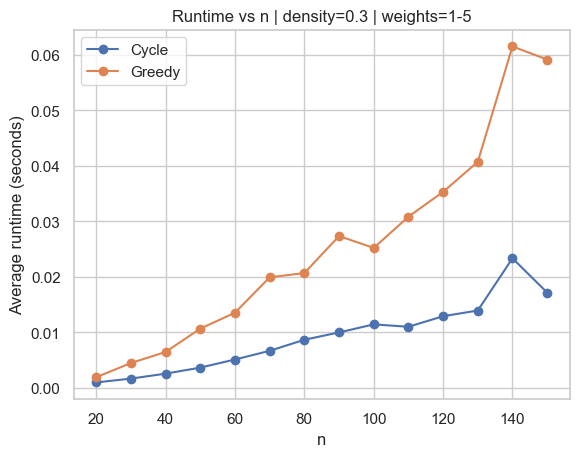

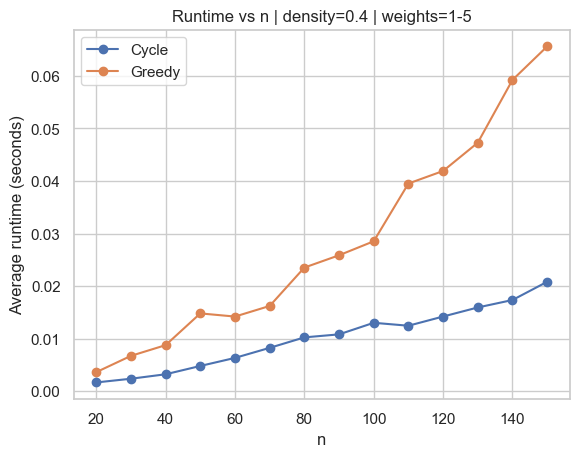

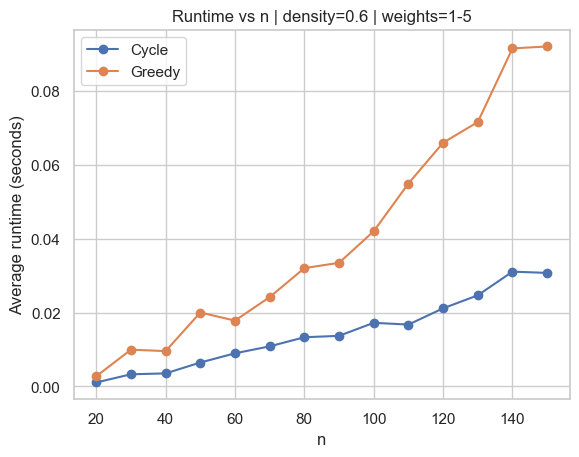

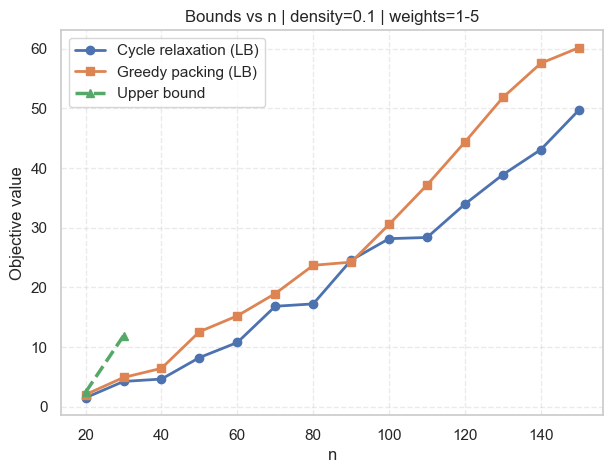

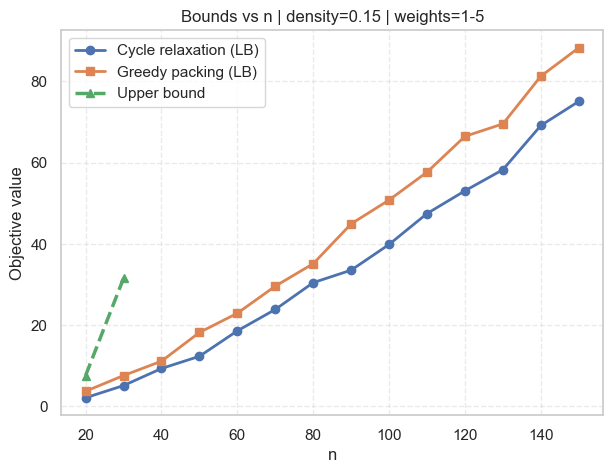

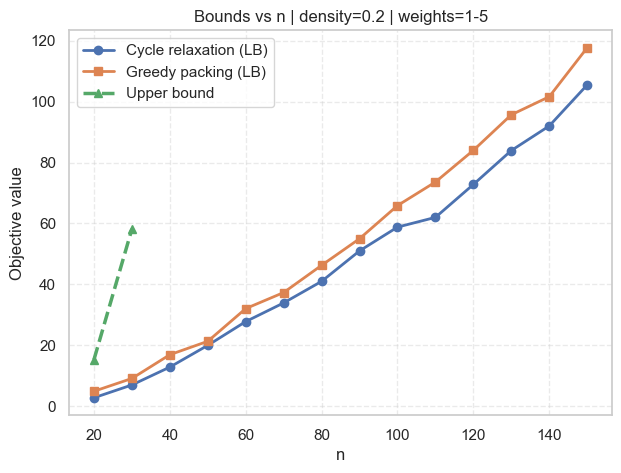

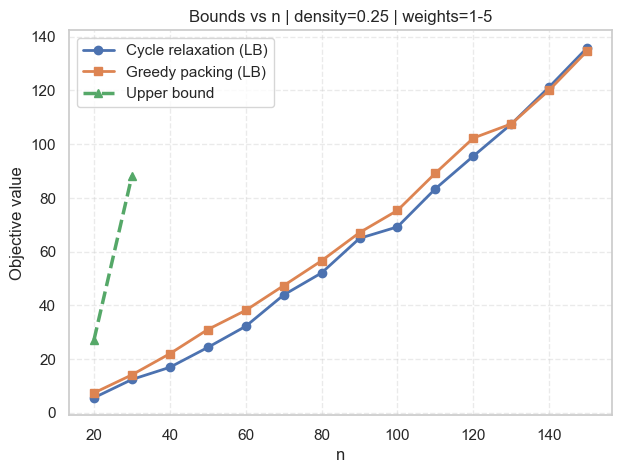

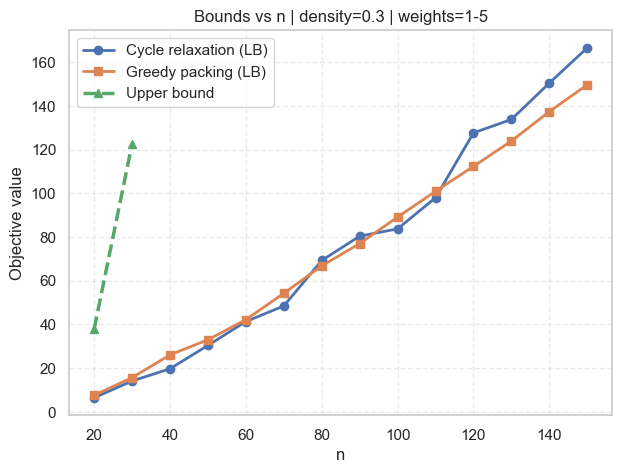

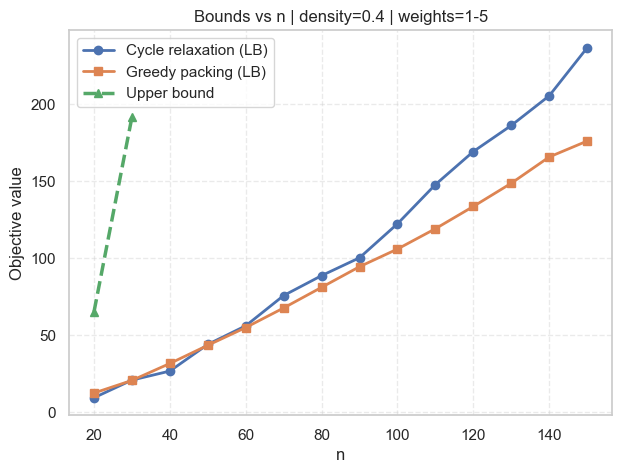

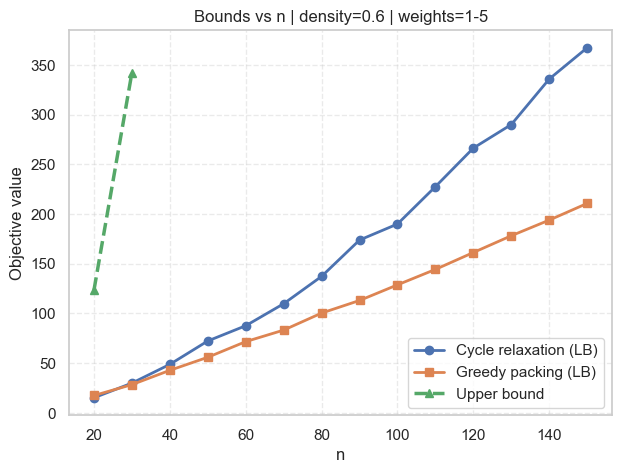

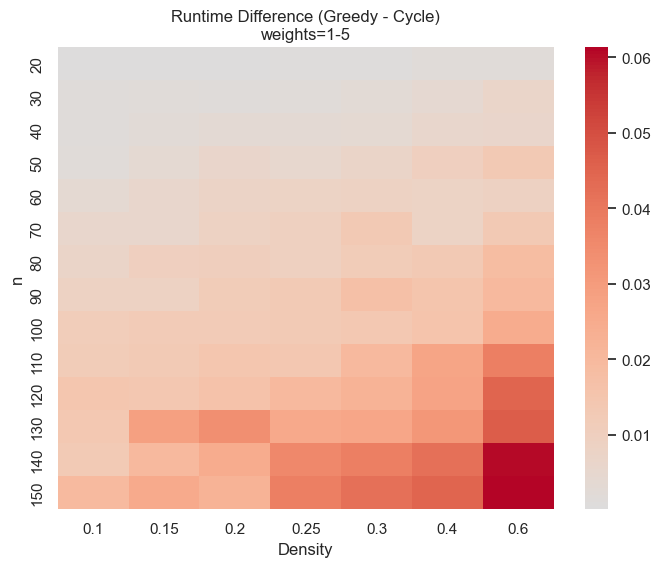

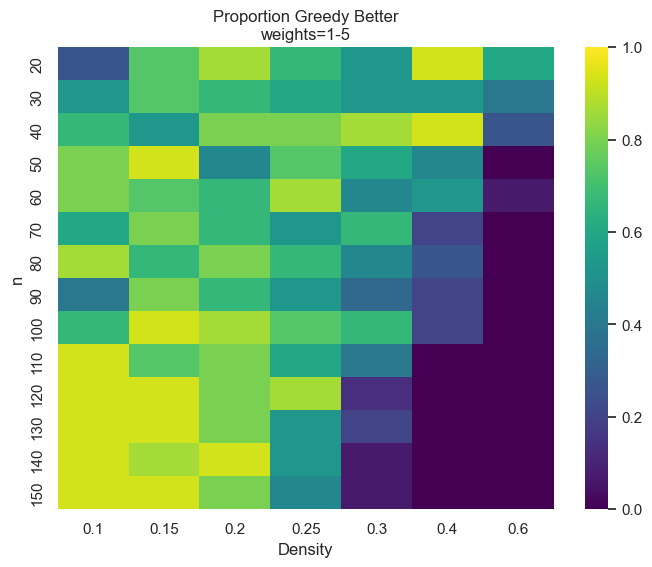

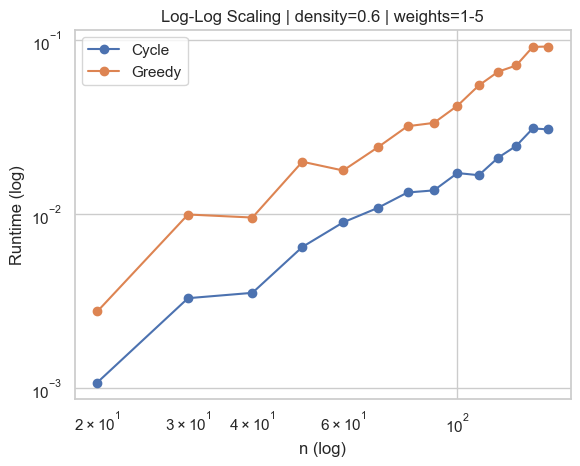

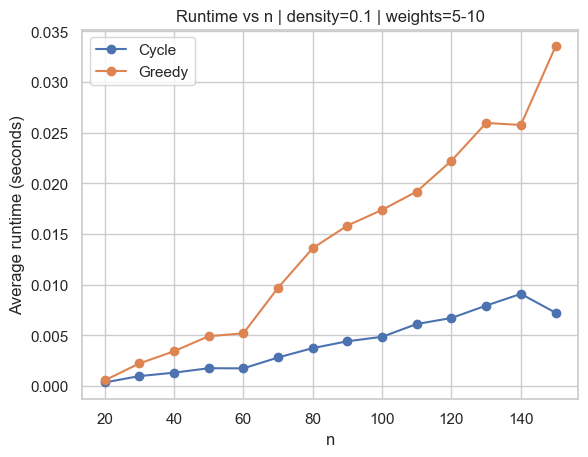

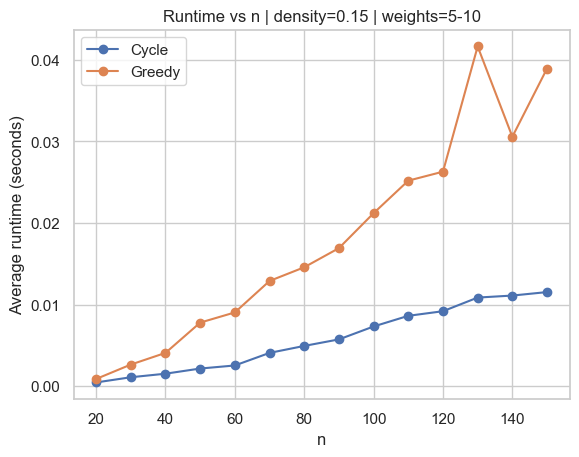

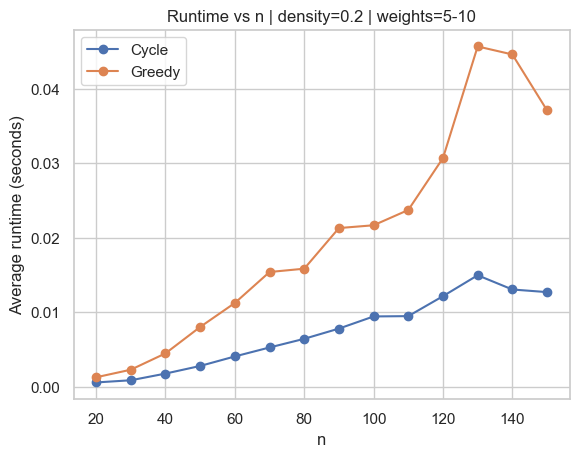

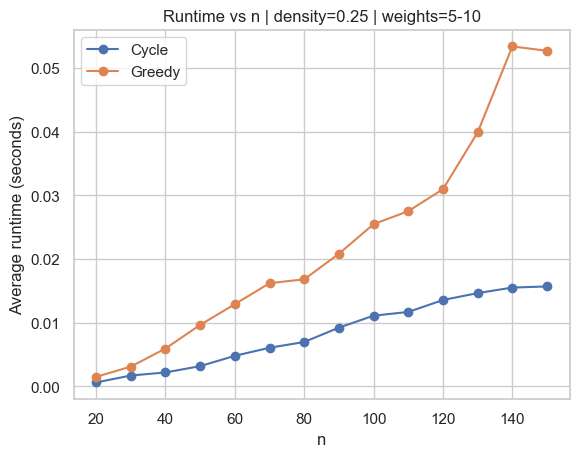

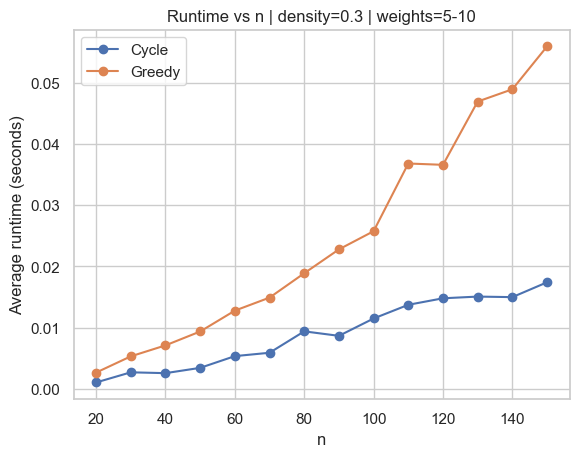

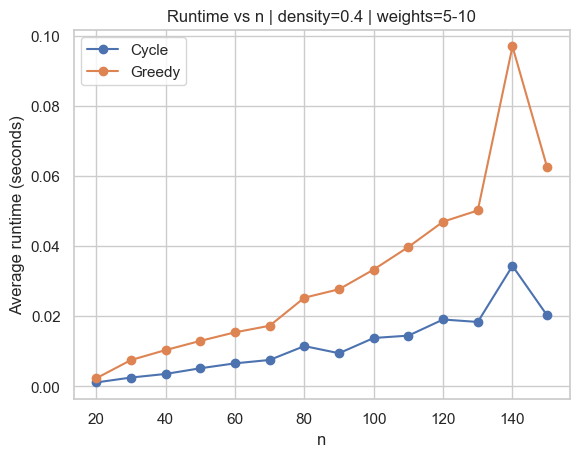

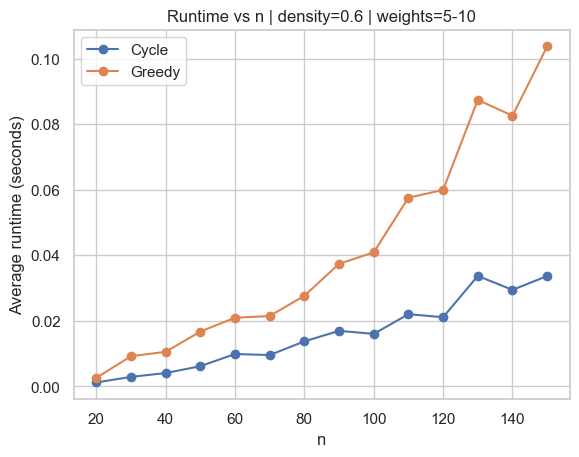

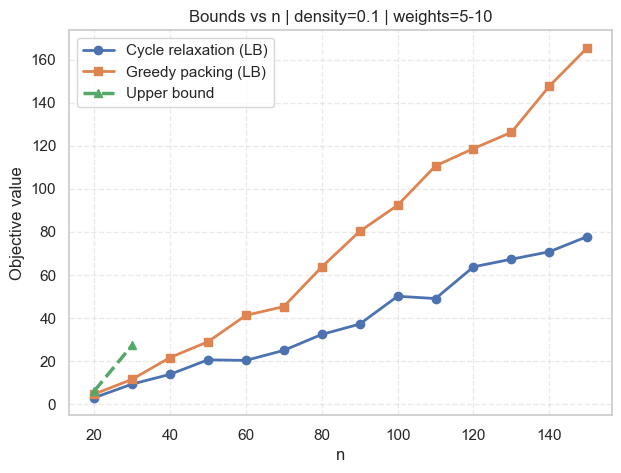

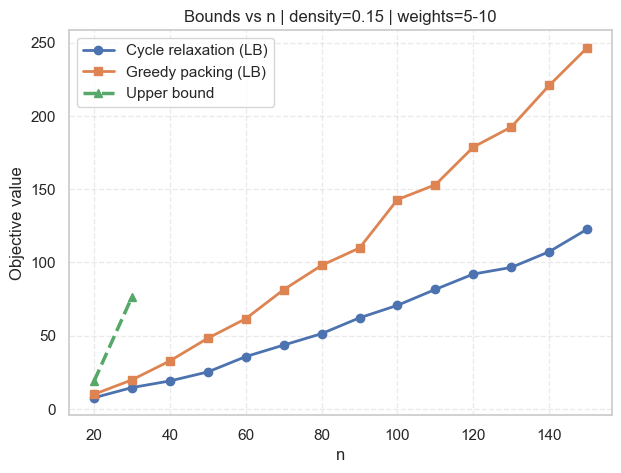

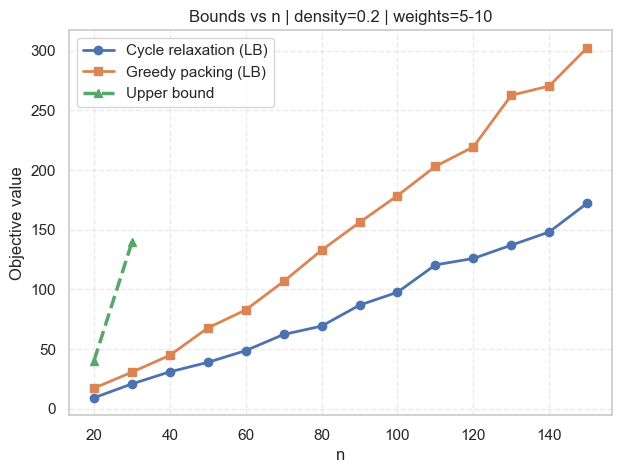

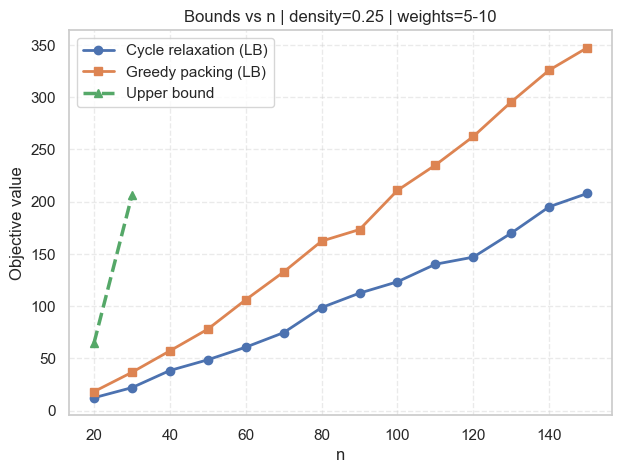

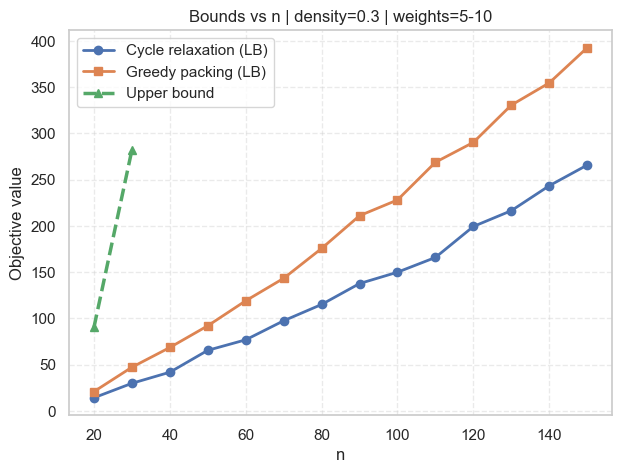

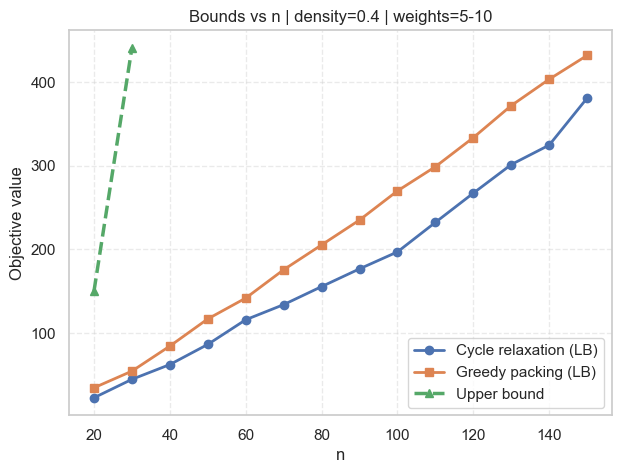

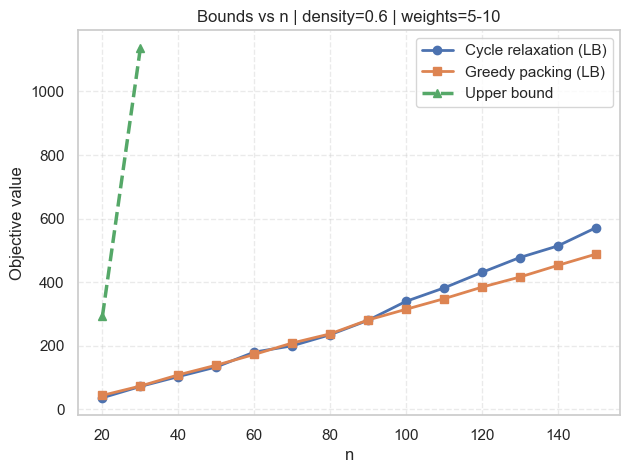

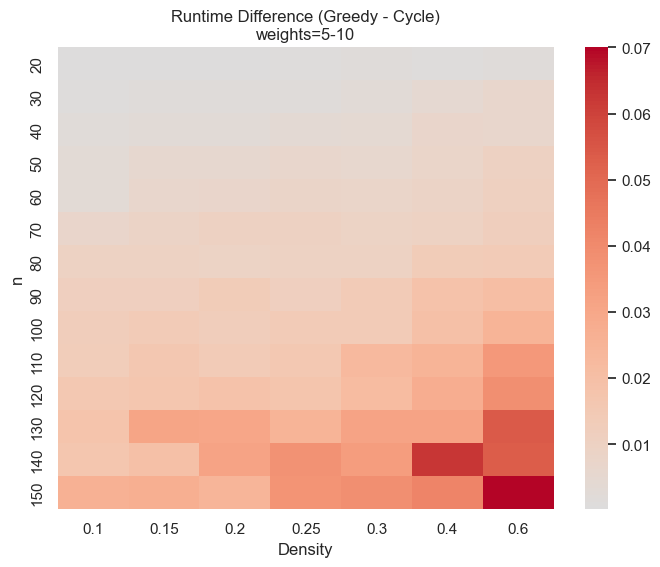

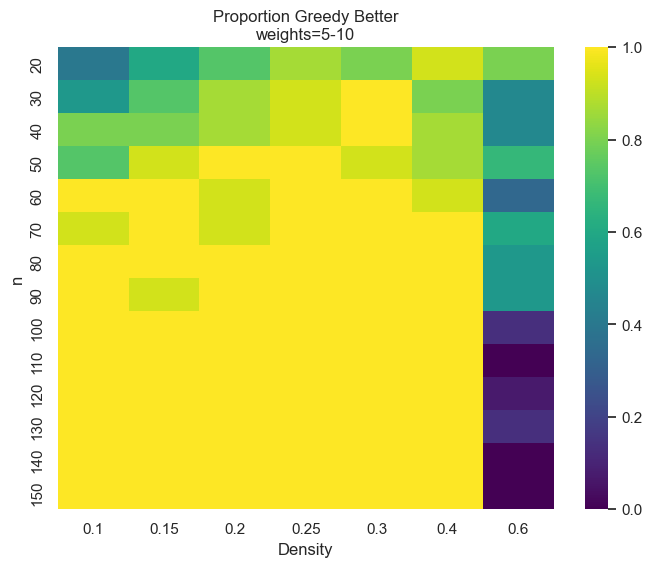

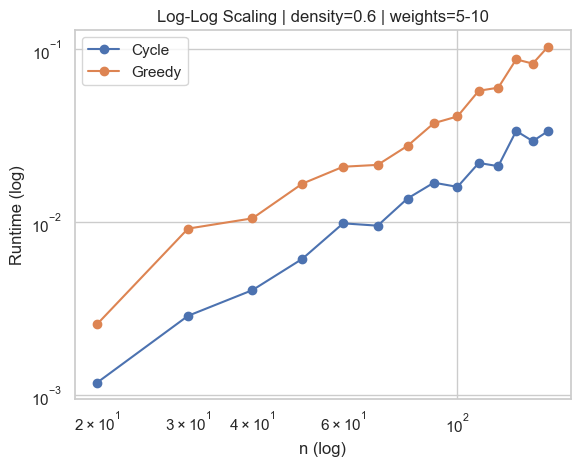

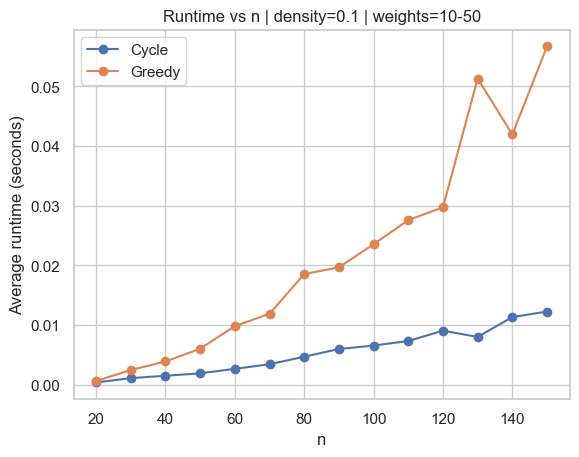

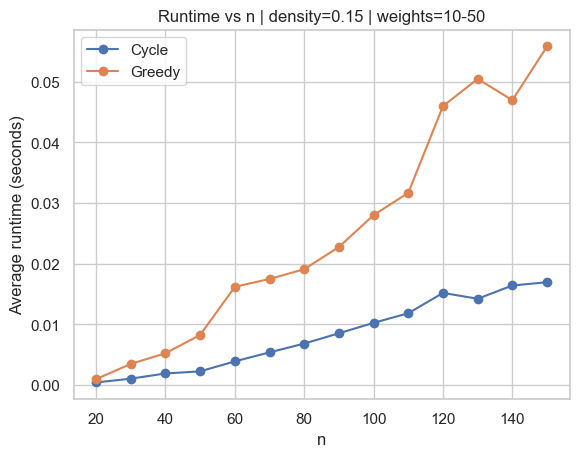

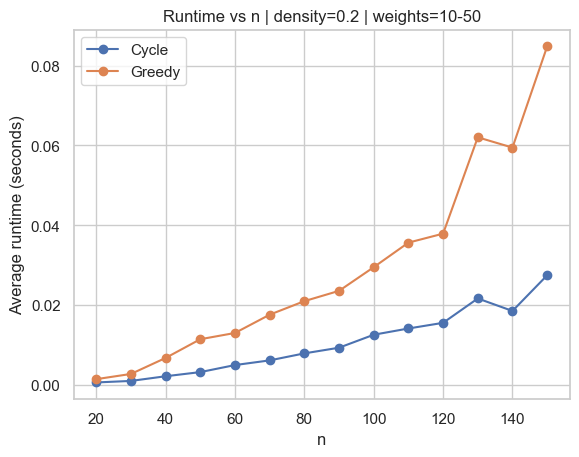

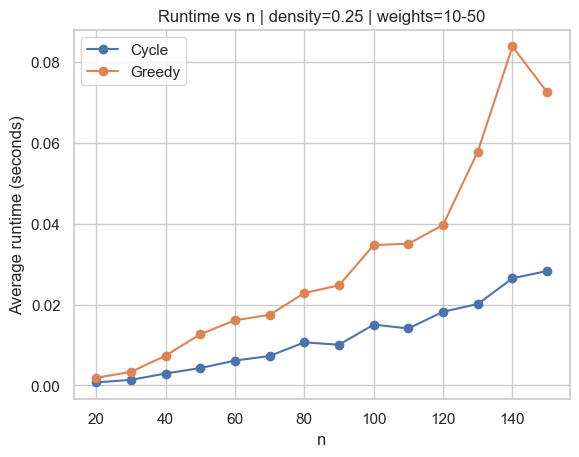

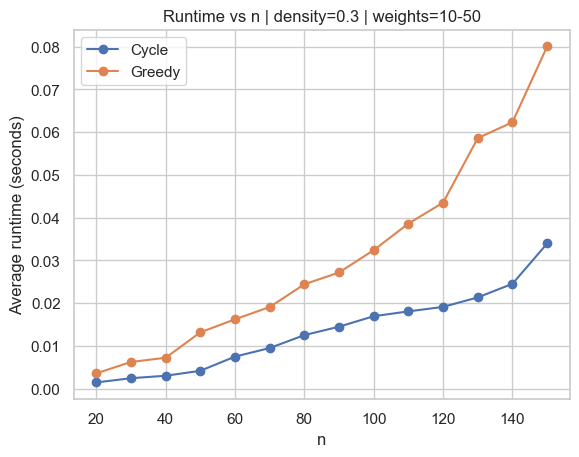

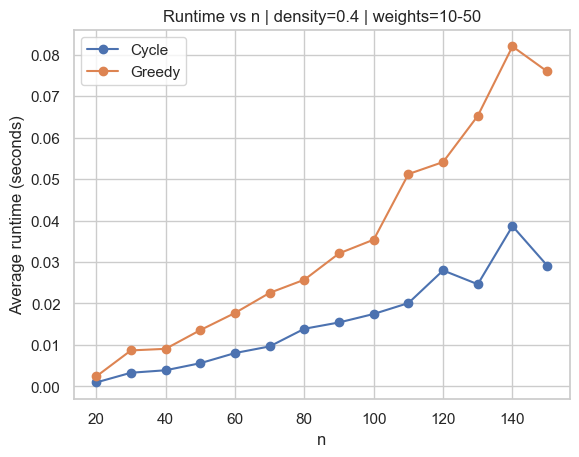

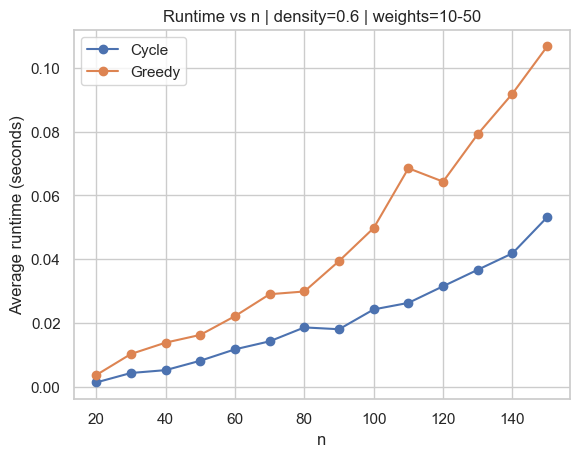

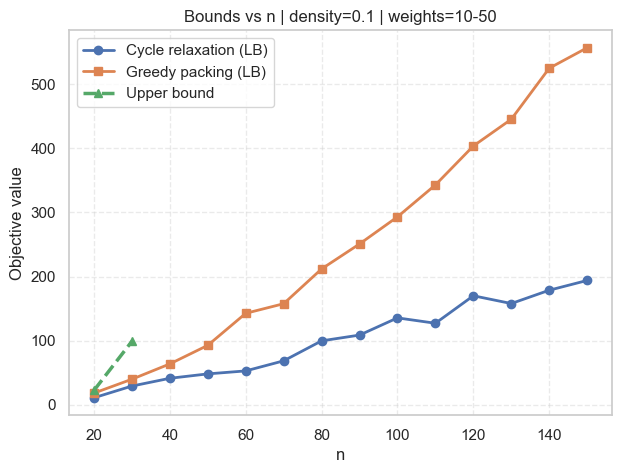

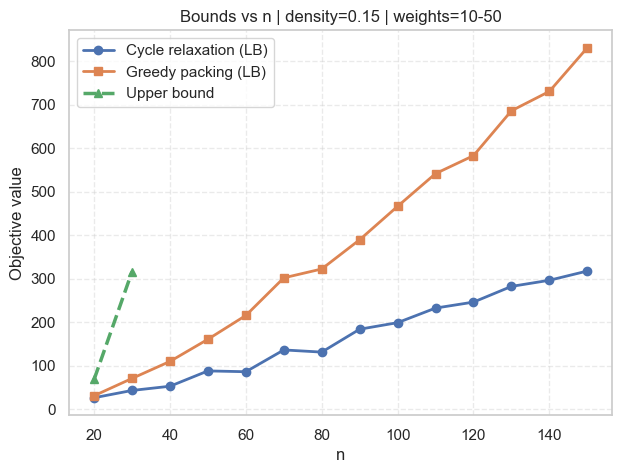

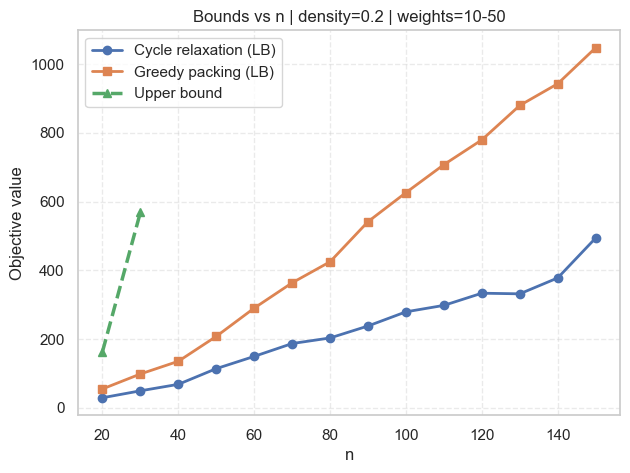

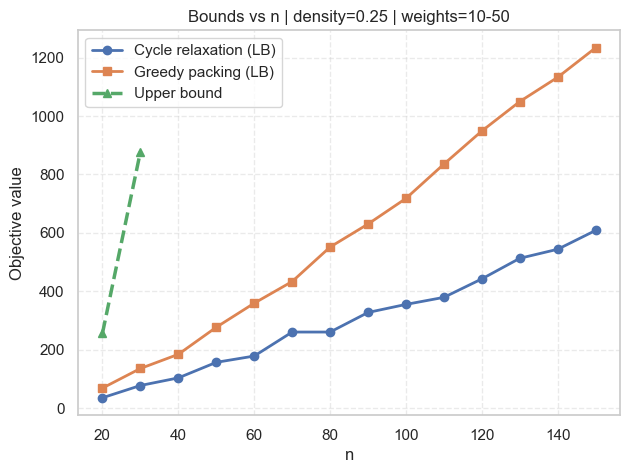

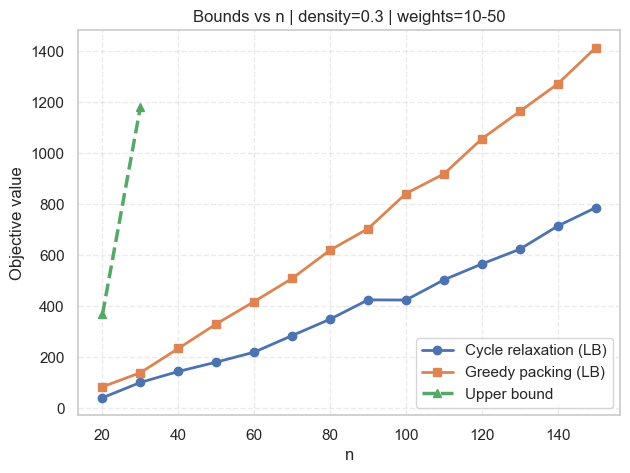

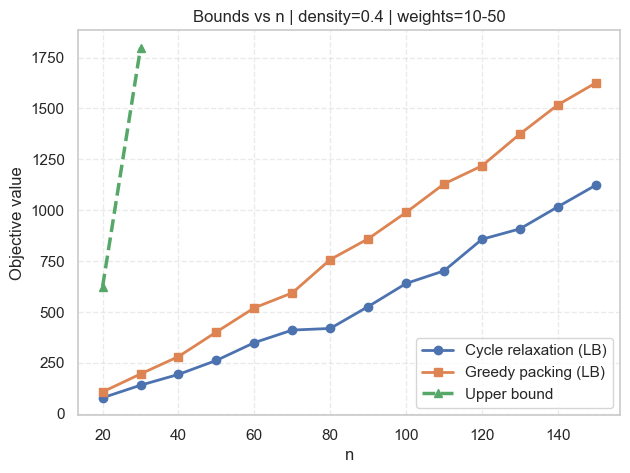

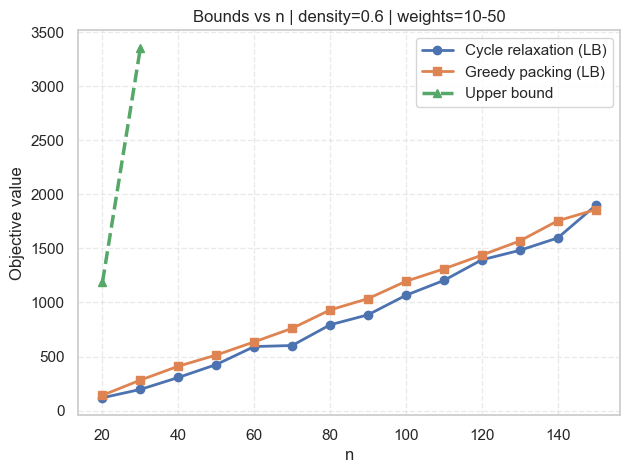

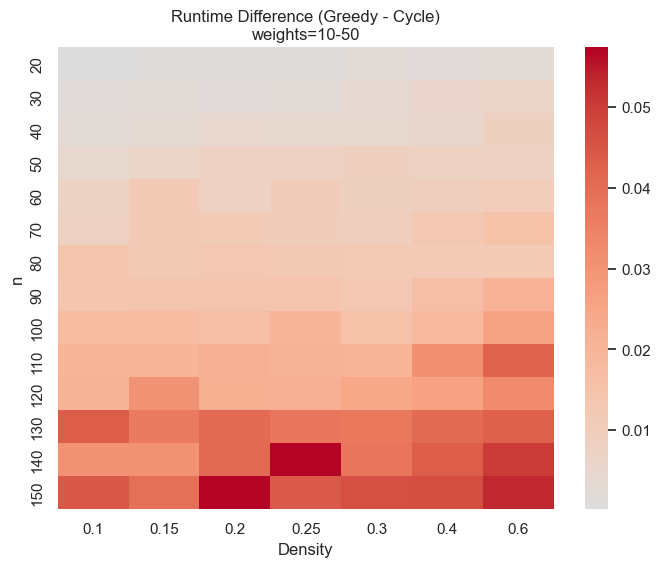

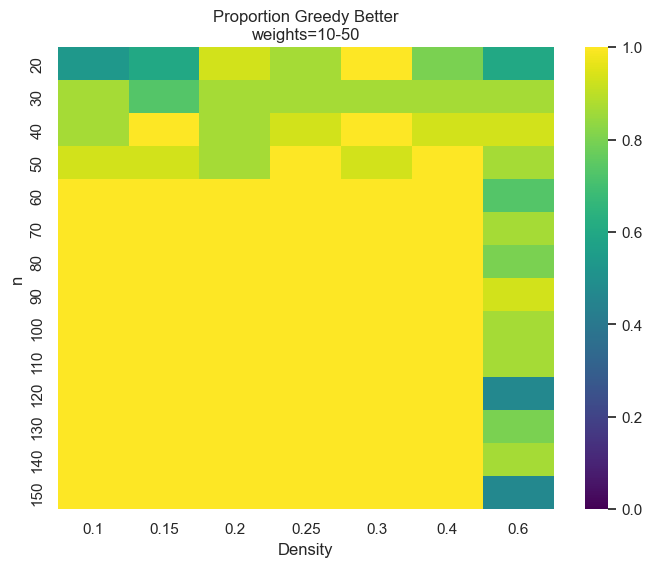

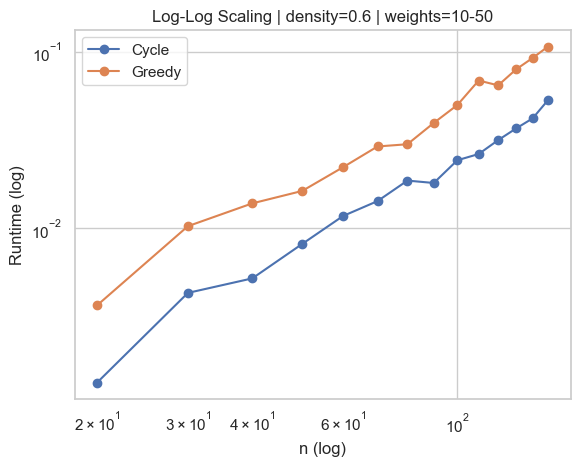

All plots generated.


In [29]:
plot_all_experiments("experiment_results.csv")

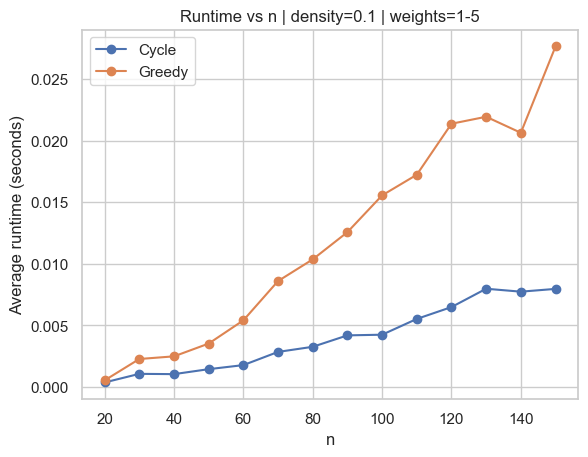

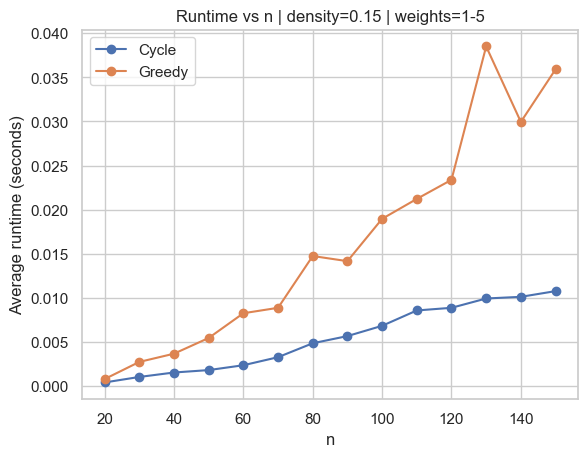

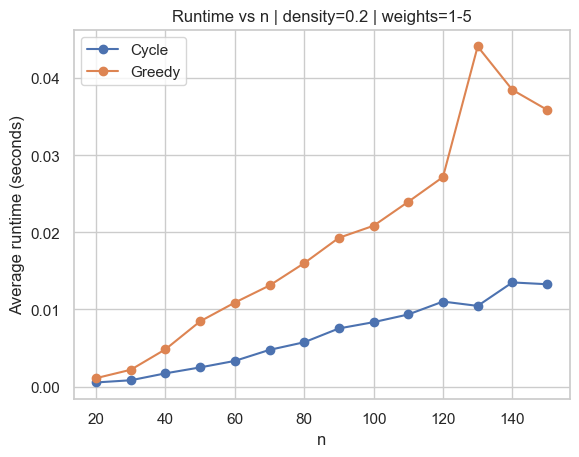

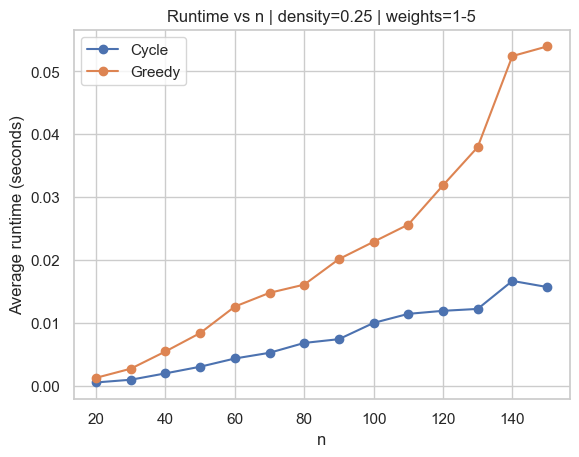

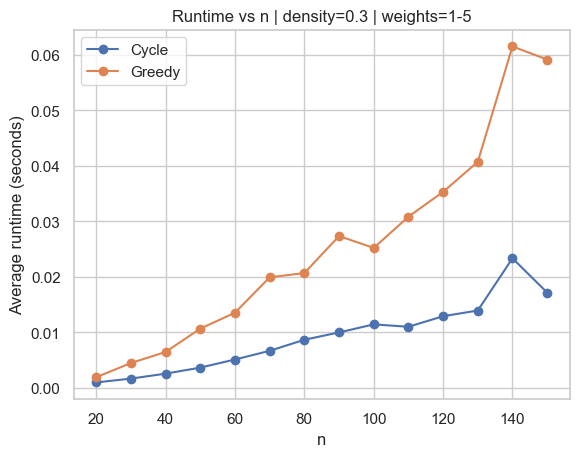

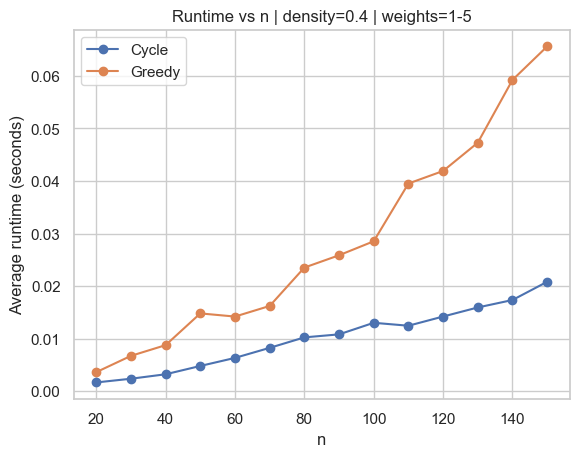

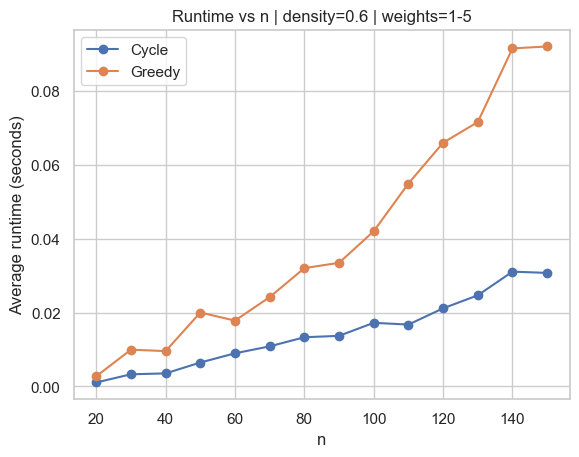

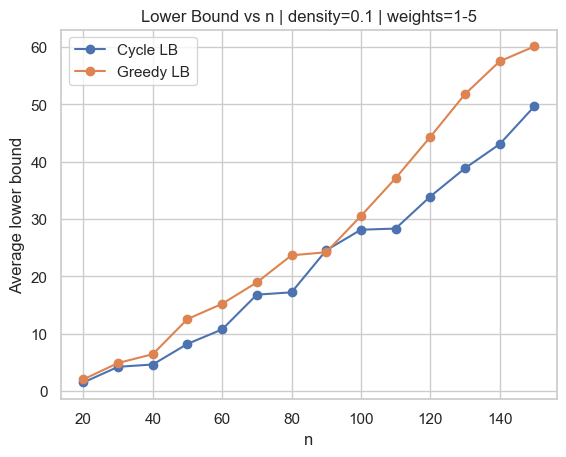

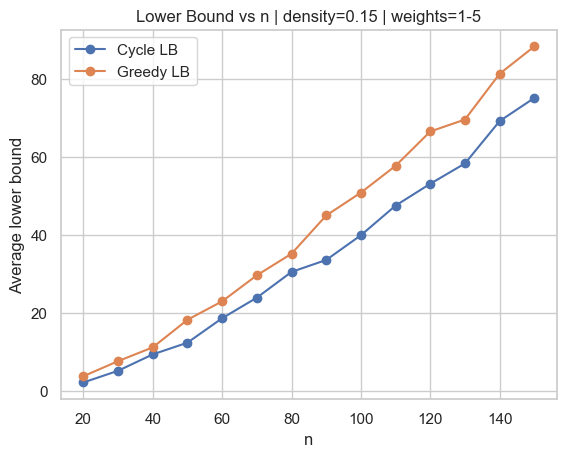

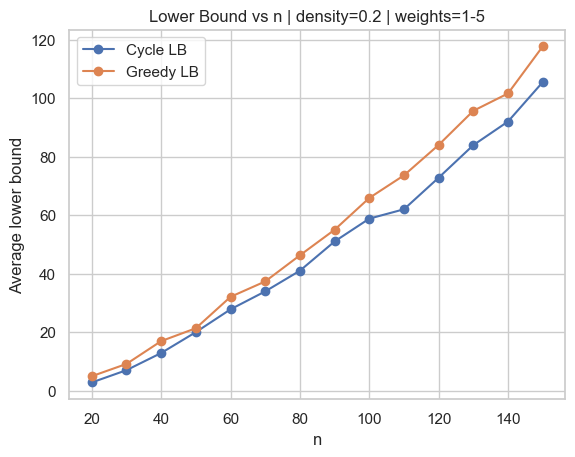

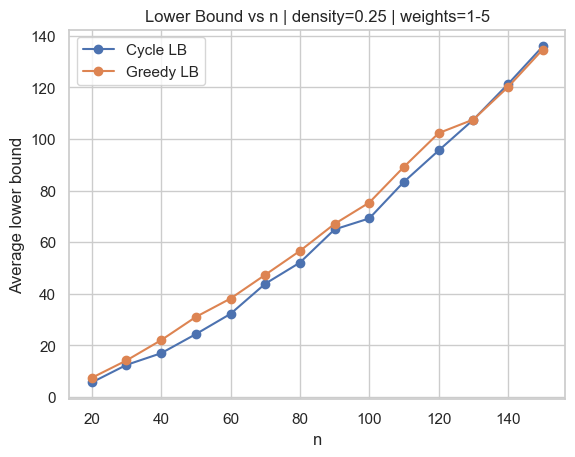

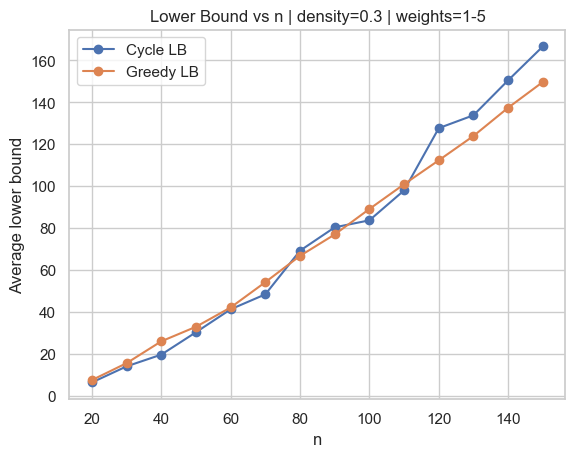

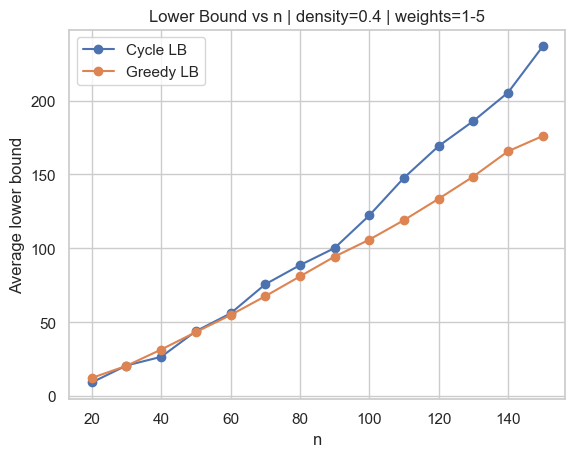

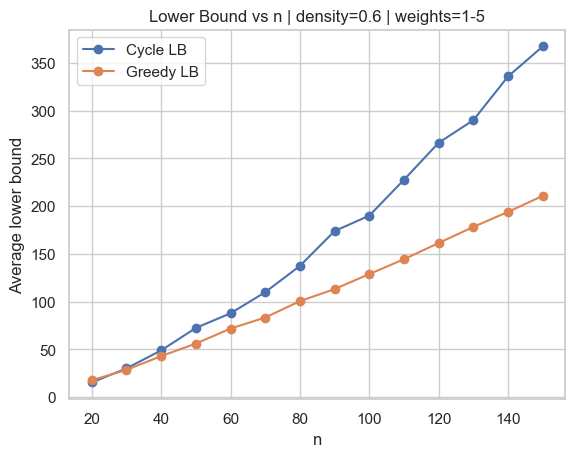

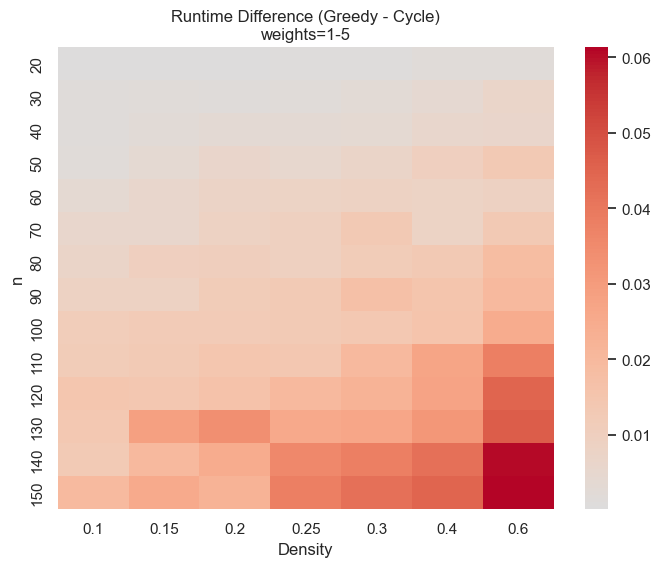

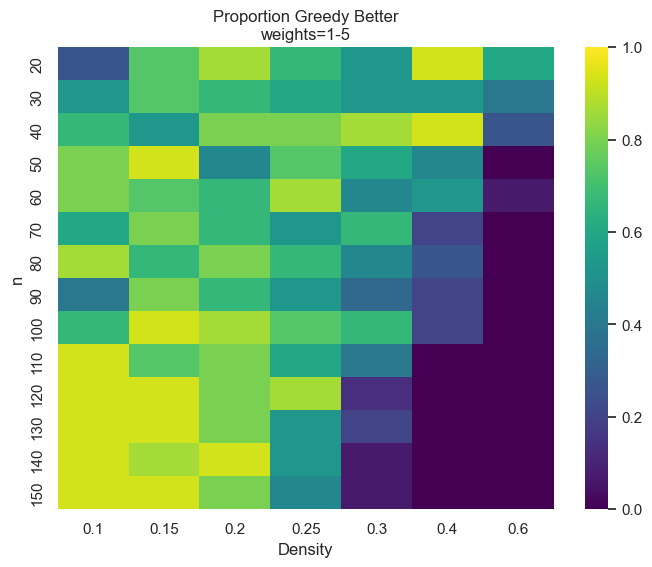

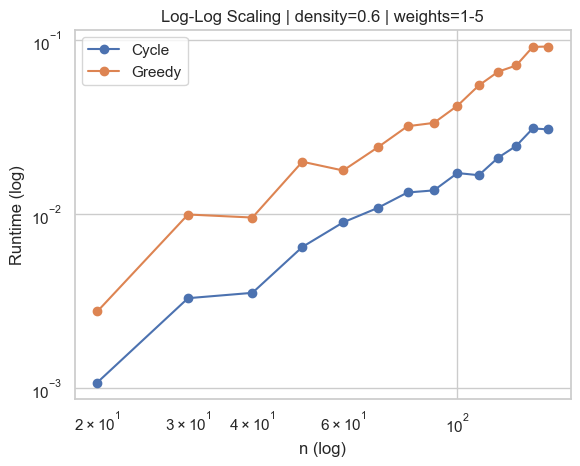

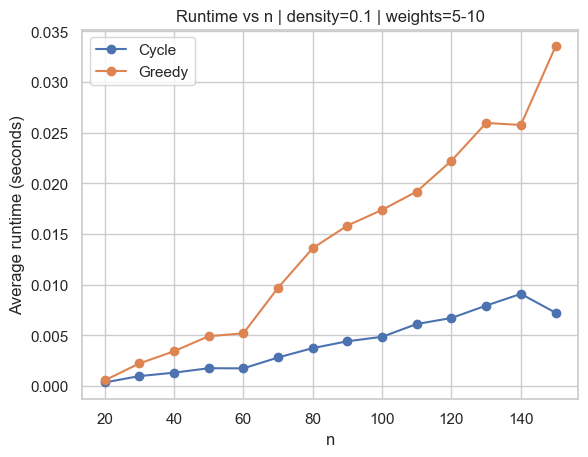

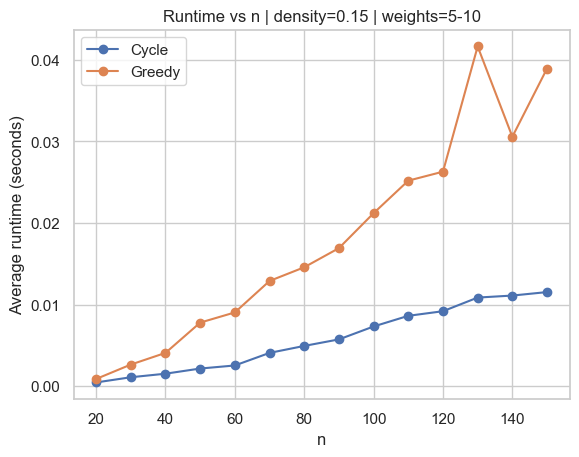

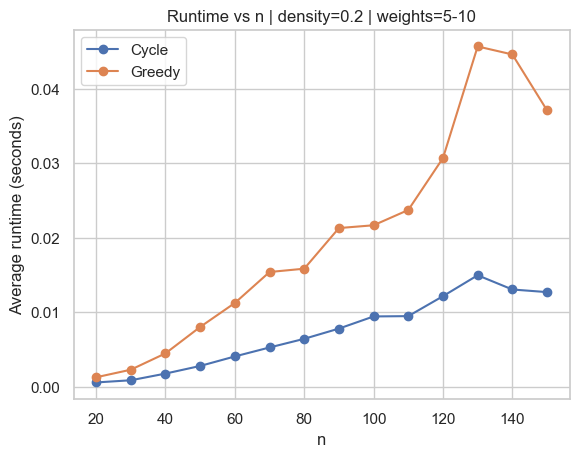

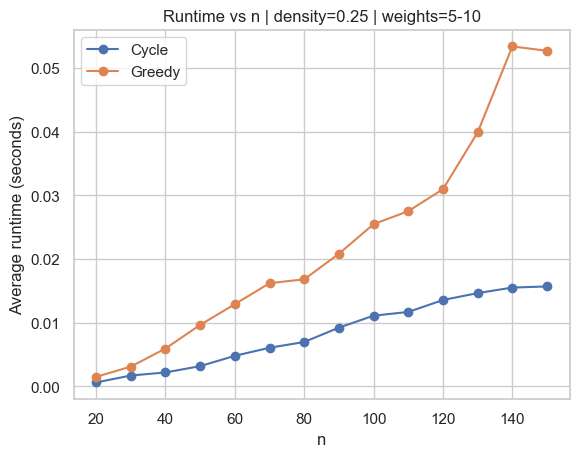

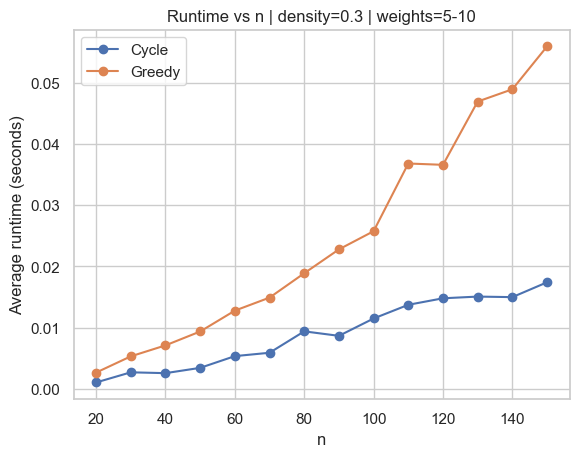

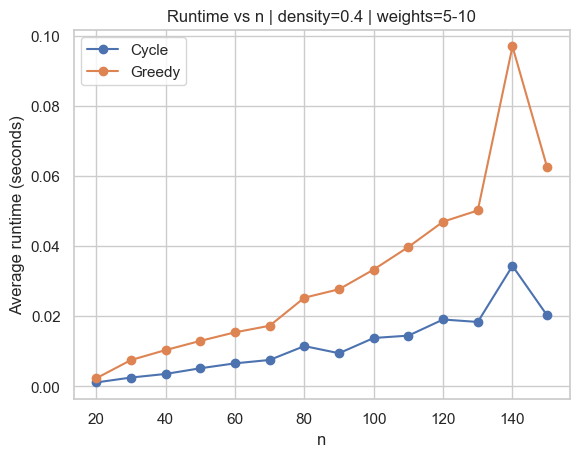

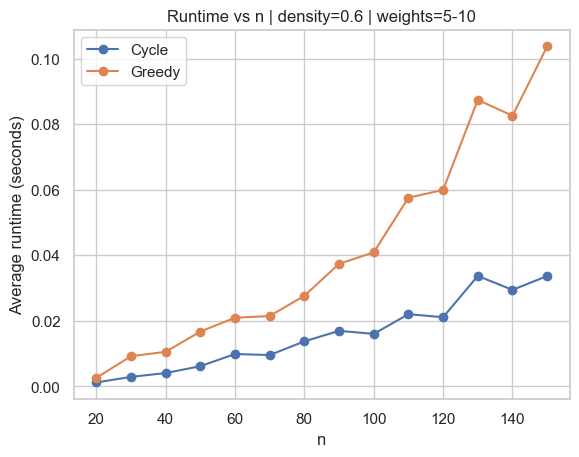

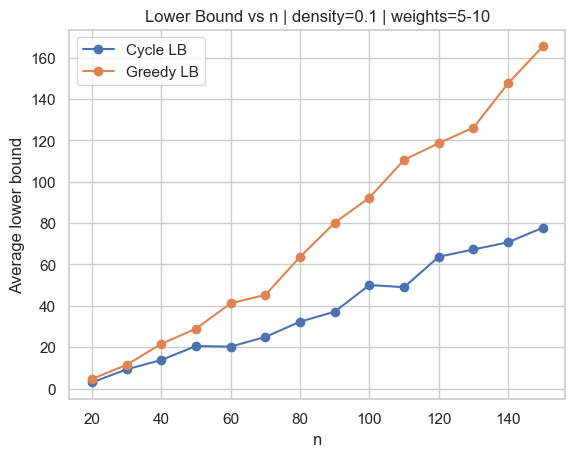

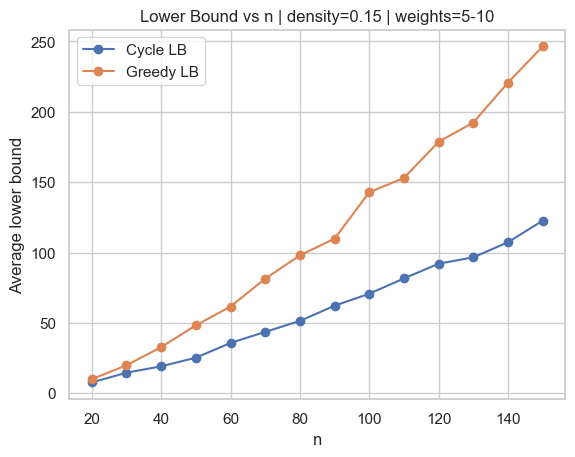

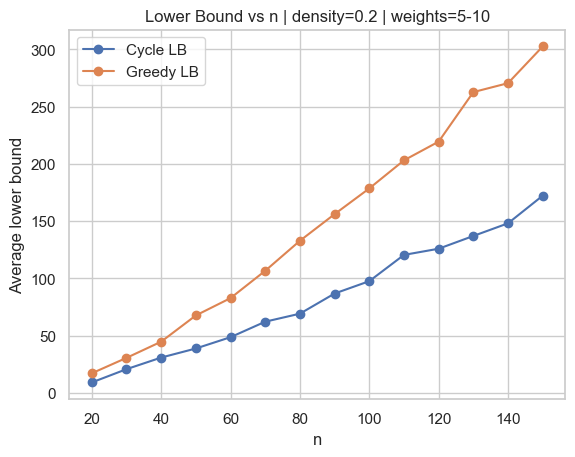

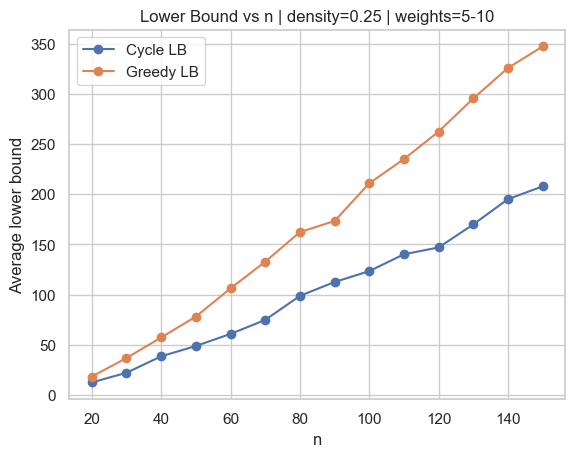

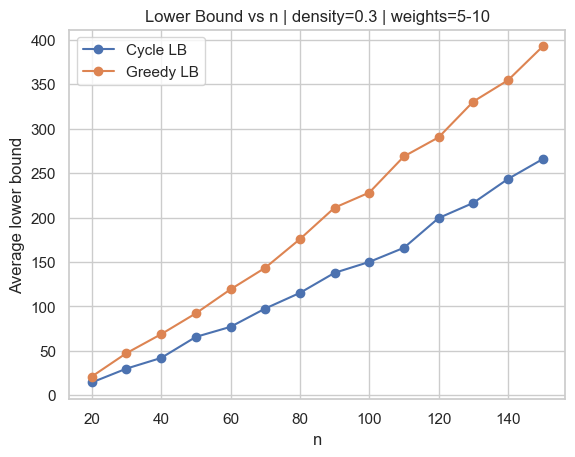

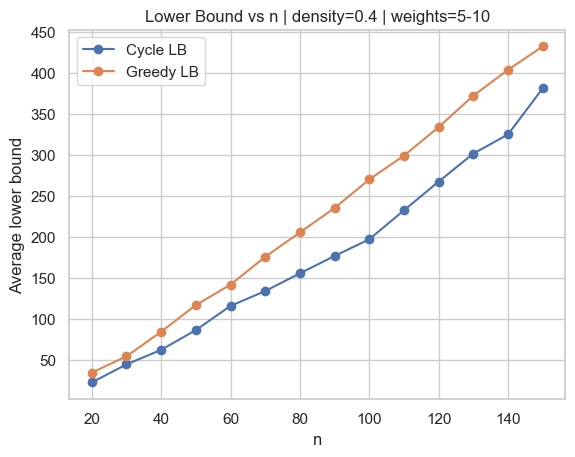

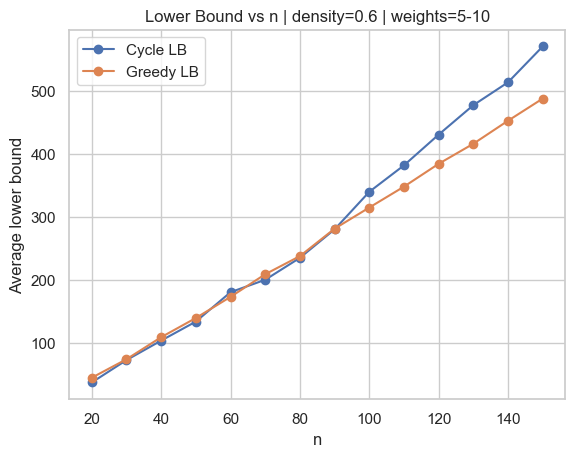

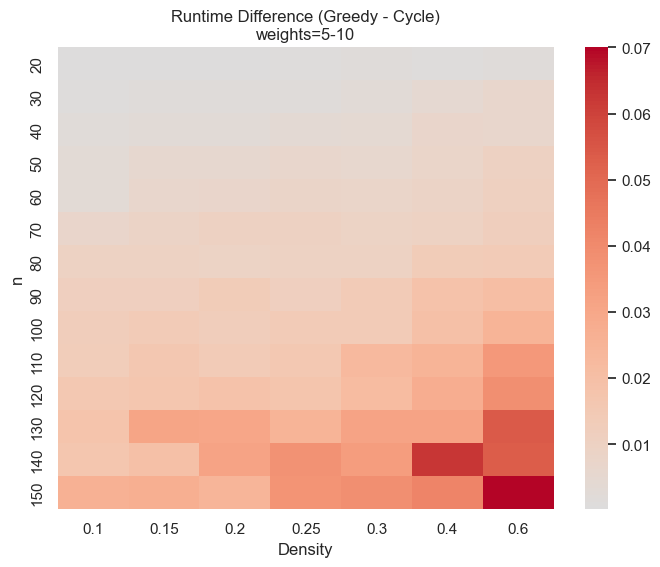

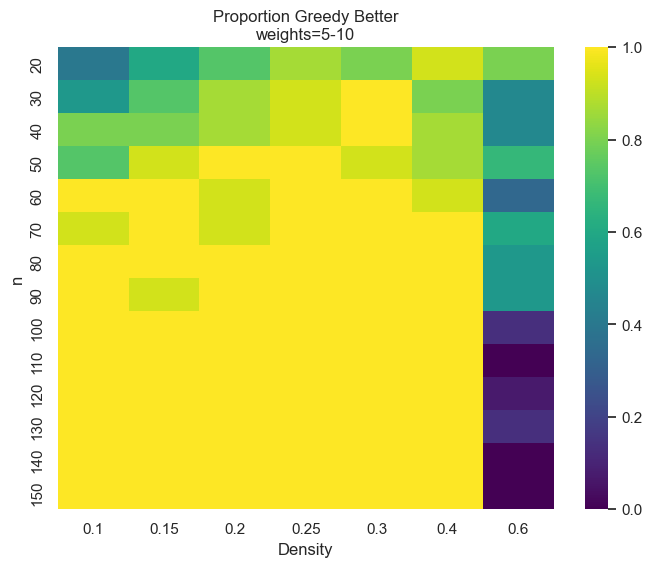

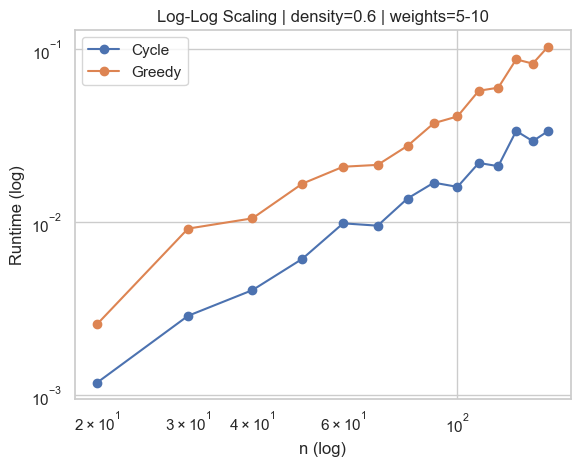

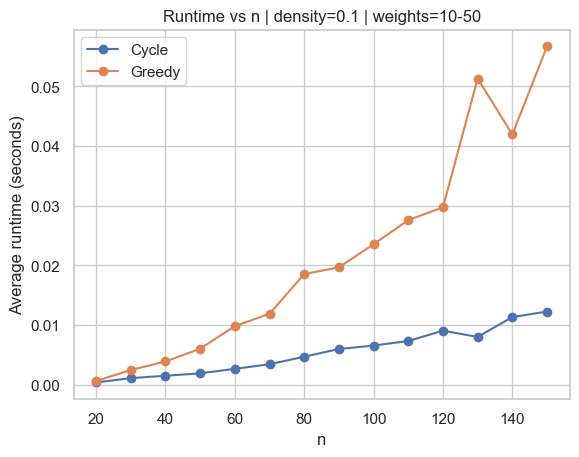

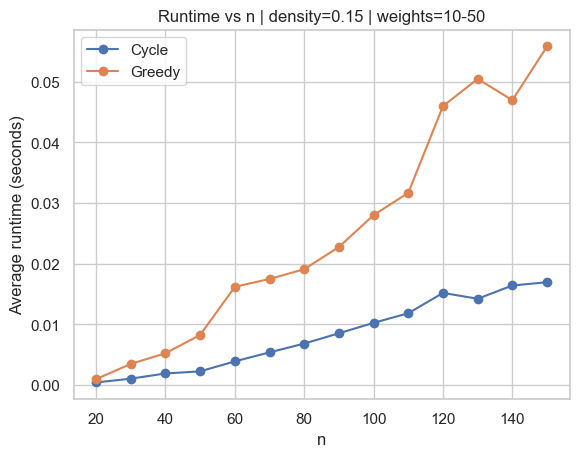

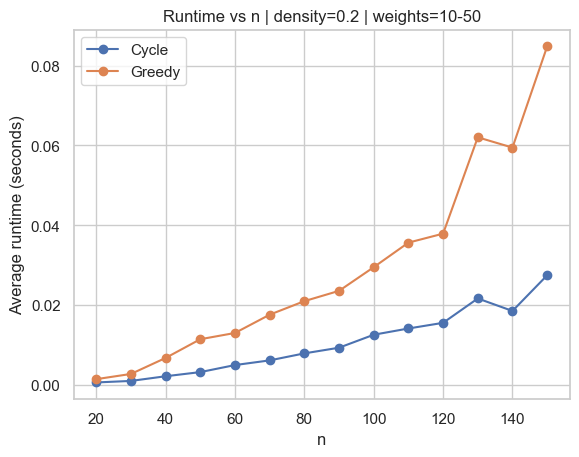

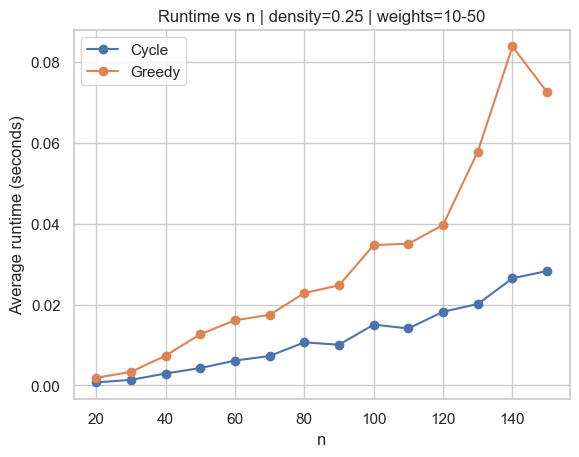

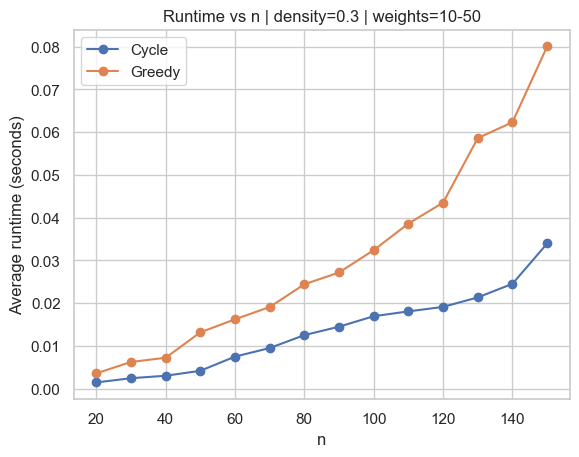

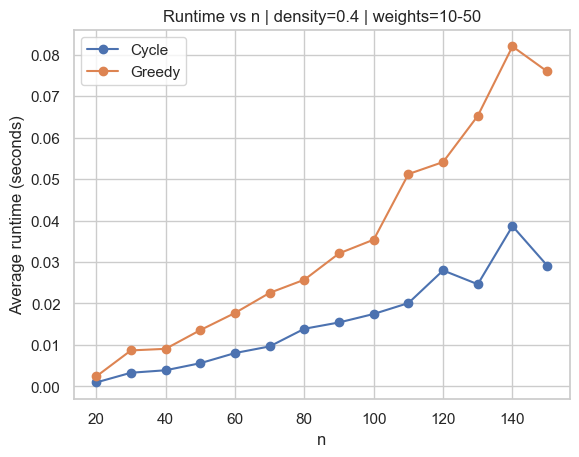

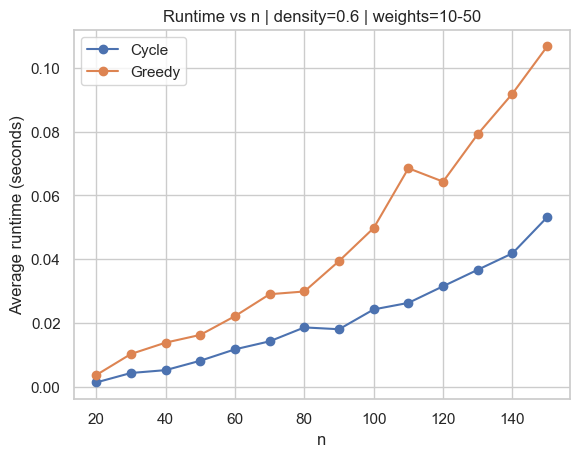

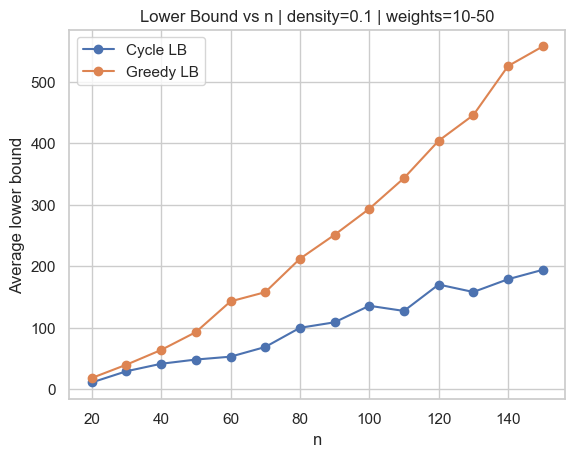

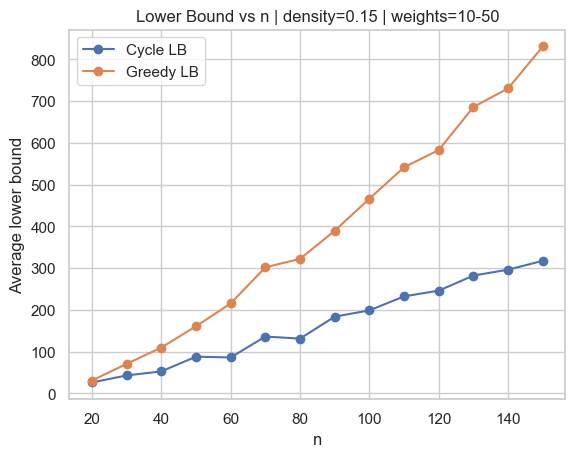

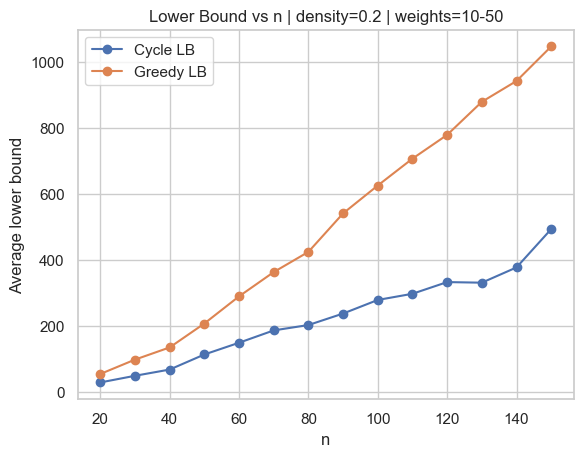

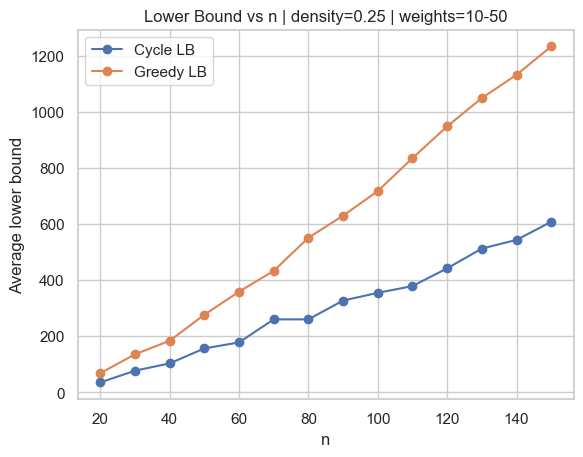

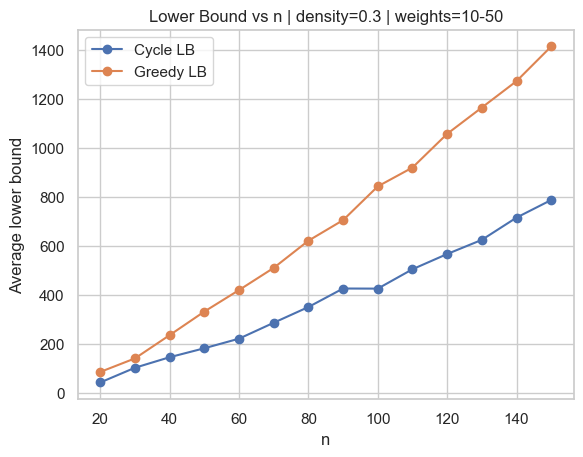

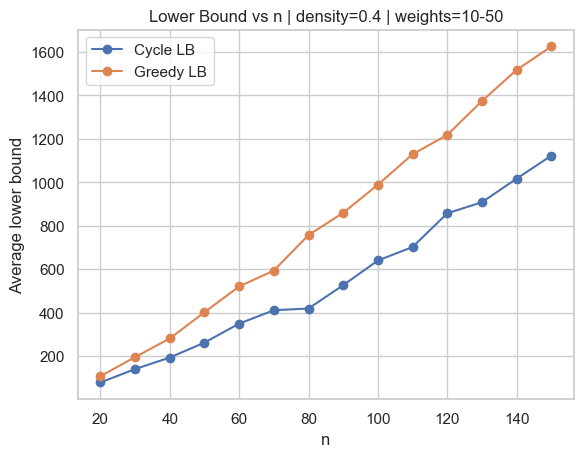

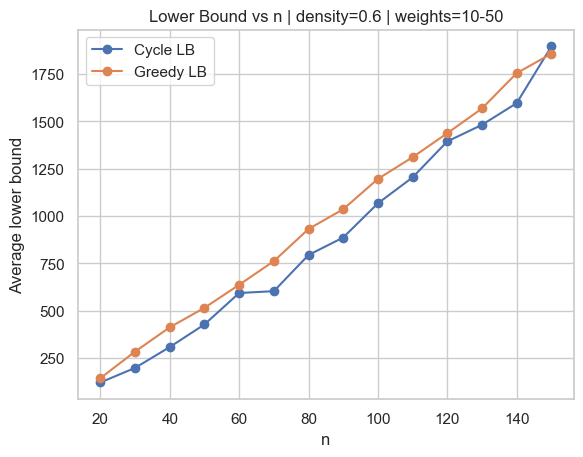

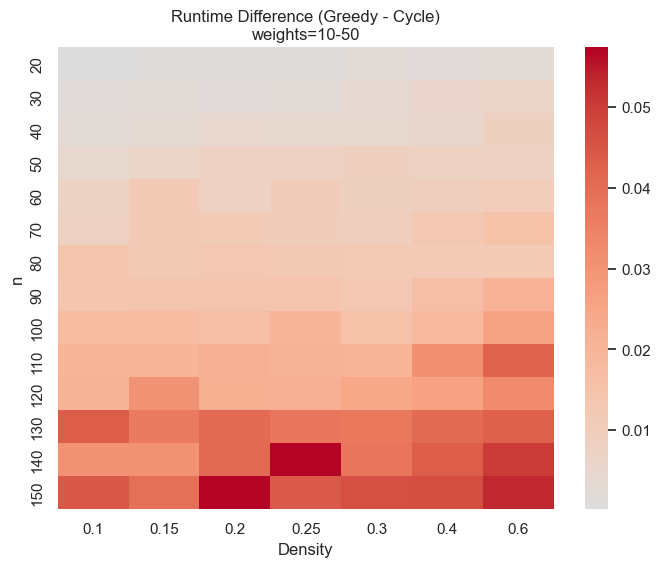

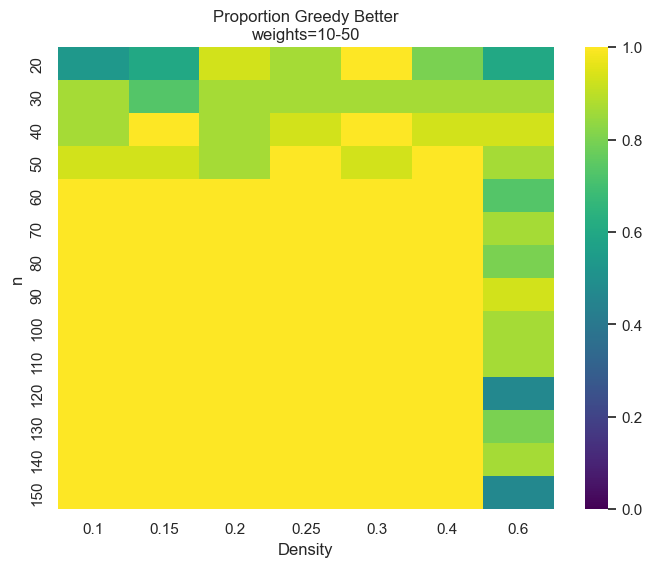

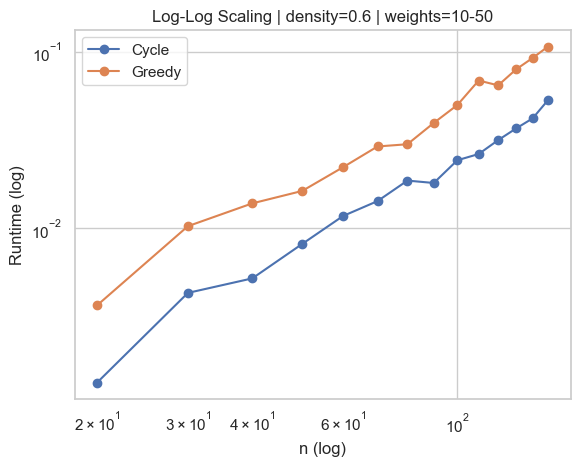

All plots generated.


In [20]:
plot_all_experiments("experiment_results.csv")